In [6]:
import h5py
import numpy as np

In [7]:

def read_fidelity_stats(hdf5_file):
    """
    Reads the Fidelity field from the HDF5 file and calculates the minimum, mean, and median Fidelity
    for each time duration of training for each gamma.

    Parameters:
    hdf5_file (str): Path to the HDF5 file.

    Returns:
    fidelity_stats (dict): A dictionary with gamma values as keys and sub-dictionaries containing arrays of 
                           min, mean, and median fidelities indexed by sorted time durations.
    """
    fidelity_stats = {}

    with h5py.File(hdf5_file, 'r') as f:
        # Iterate over all gamma groups
        for gamma_key in f.keys():
            print(f"Processing gamma: {gamma_key}")
            
            gamma_group = f[gamma_key]  # Access the gamma group
            
            min_fidelities = []
            mean_fidelities = []
            median_fidelities = []
            durations = []

            # Iterate over time duration groups inside each gamma group
            for duration_key in gamma_group.keys():
                duration_group = gamma_group[duration_key]

                all_fidelities = []
                # Collect all fidelity values for this time duration
                for state_key in [f"D{i}" for i in range(1, 11)]:
                    if state_key in duration_group:
                        state_group = duration_group[state_key]
                        
                        # Read the Fidelity data
                        if 'Fidelity' in state_group:
                            fidelity_data = state_group['Fidelity'][()]
                            
                            # Check if Fidelity is a scalar or an array
                            if np.isscalar(fidelity_data):
                                all_fidelities.append(fidelity_data)  # Append scalar directly
                            else:
                                all_fidelities.extend(fidelity_data)  # Flatten and append array elements

                # If we have collected fidelities for this time duration, calculate stats
                if all_fidelities:
                    all_fidelities = np.array(all_fidelities)
                    min_fidelity = np.min(all_fidelities)
                    mean_fidelity = np.mean(all_fidelities)
                    median_fidelity = np.median(all_fidelities)

                    # Store the values
                    min_fidelities.append(min_fidelity)
                    mean_fidelities.append(mean_fidelity)
                    median_fidelities.append(median_fidelity)
                    durations.append(float(duration_key))

            # Convert lists to arrays
            durations = np.array(durations)
            min_fidelities = np.array(min_fidelities)
            mean_fidelities = np.array(mean_fidelities)
            median_fidelities = np.array(median_fidelities)

            # Sort arrays by durations
            sorted_indices = np.argsort(durations)
            durations = durations[sorted_indices]
            min_fidelities = min_fidelities[sorted_indices]
            mean_fidelities = mean_fidelities[sorted_indices]
            median_fidelities = median_fidelities[sorted_indices]

            # Store the sorted results for the current gamma
            fidelity_stats[gamma_key] = {
                'durations': durations,
                'min_fidelity': min_fidelities,
                'mean_fidelity': mean_fidelities,
                'median_fidelity': median_fidelities
            }

    return fidelity_stats

In [8]:
# Example usage
hdf5_file = 'MULT_KOSSAK_CONSTR_TSSOS_threshold_1e-15_FROB_QO_2024-Sep-29_at_19-10.h5'
fidelity_stats = read_fidelity_stats(hdf5_file)

# Example: Access the min, mean, and median fidelities for gamma "0.079477"
print(f"Durations for gamma 0.079477: {fidelity_stats['0.079477']['durations']}")
print(f"Min fidelities for gamma 0.079477: {fidelity_stats['0.079477']['min_fidelity']}")
print(f"Mean fidelities for gamma 0.079477: {fidelity_stats['0.079477']['mean_fidelity']}")
print(f"Median fidelities for gamma 0.079477: {fidelity_stats['0.079477']['median_fidelity']}")

Processing gamma: 0.079477
Processing gamma: 0.25133
Processing gamma: 0.79477
Processing gamma: 2.5133
Processing gamma: 25.133
Processing gamma: 251.33
Processing gamma: 7.9477
Processing gamma: 79.477
Durations for gamma 0.079477: [ 6.29112825 12.5822565  18.87338475]
Min fidelities for gamma 0.079477: [0.97013703 0.97291899 0.97541562]
Mean fidelities for gamma 0.079477: [0.99364716 0.99425243 0.9948099 ]
Median fidelities for gamma 0.079477: [0.99651721 0.99687732 0.99717723]


In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [37]:
def plot_fidelity_stats(fidelity_stats):
    """
    Plots the fidelity statistics for each gamma on the same plot using sorted gamma values
    and a plasma color palette.

    Parameters:
    fidelity_stats (dict): The dictionary containing fidelity statistics for each gamma.
    """
    # Sort gamma keys by their numeric value
    sorted_gamma_keys = sorted(fidelity_stats.keys(), key=lambda x: float(x))
    
    # Use the plasma colormap
    cmap = cm.get_cmap('plasma', len(sorted_gamma_keys))

    plt.figure(figsize=(10, 6))

    # Iterate over sorted gamma keys and plot its min, mean, and median fidelities
    for i, gamma_key in enumerate(sorted_gamma_keys):
        stats = fidelity_stats[gamma_key]
        durations = stats['durations']
        min_fidelity = stats['min_fidelity']
        mean_fidelity = stats['mean_fidelity']
        median_fidelity = stats['median_fidelity']

        color = cmap(i)  # Assign a color from the plasma colormap

        # Plot lines for each fidelity type with the same color for the same gamma
        #plt.plot(durations, min_fidelity, color=color, alpha=0.5)  # Using same color but semi-transparent
        #plt.plot(durations, mean_fidelity, color=color, alpha=0.8, label=f'γ = {gamma_key}')  # Main line
        #plt.plot(durations, median_fidelity, color=color, alpha=0.5)

        gamma_durations = [i/2 for i in range(1, len(mean_fidelity)+1)]

        #plt.plot(min_fidelity, color=color, alpha=0.8, label=f'γ = {gamma_key}')  # Using same color but semi-transparent
        plt.plot(gamma_durations, mean_fidelity, color=color, alpha=0.8, label=f'γ = {gamma_key}')  # Main line
        #plt.plot(median_fidelity, color=color, alpha=0.5)


    # Add plot labels and legend
    plt.xlim(0,8)

    plt.xlabel(r'Training duration, $\gamma^{-1}$')
    plt.ylabel(r'Fidelity, $F$')
    plt.title('Fidelity of Kossakowski models')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    
    # Show the plot
    plt.show()

/tmp/ipykernel_369314/4279866694.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(sorted_gamma_keys))


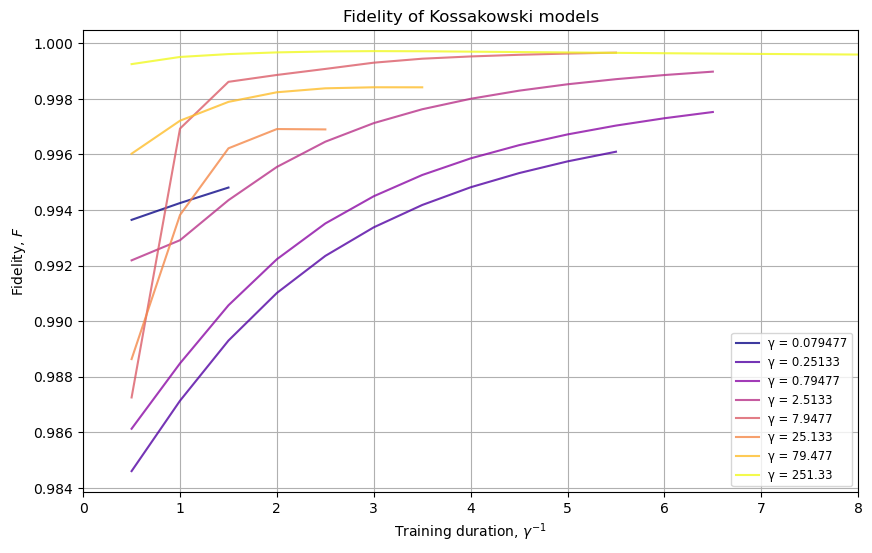

In [38]:
# Plot the results using the plasma colormap
plot_fidelity_stats(fidelity_stats)

In [54]:
def plot_infidelity_stats(fidelity_stats):
    """
    Plots the fidelity statistics for each gamma on the same plot using sorted gamma values
    and a plasma color palette.

    Parameters:
    fidelity_stats (dict): The dictionary containing fidelity statistics for each gamma.
    """
    # Sort gamma keys by their numeric value
    sorted_gamma_keys = sorted(fidelity_stats.keys(), key=lambda x: float(x))
    
    # Use the plasma colormap
    cmap = cm.get_cmap('plasma', len(sorted_gamma_keys))

    plt.figure(figsize=(10, 6))

    # Iterate over sorted gamma keys and plot its min, mean, and median fidelities
    for i, gamma_key in enumerate(sorted_gamma_keys):
        stats = fidelity_stats[gamma_key]
        durations = stats['durations']
        min_fidelity = stats['min_fidelity']
        mean_fidelity = stats['mean_fidelity']
        median_fidelity = stats['median_fidelity']

        color = cmap(i)  # Assign a color from the plasma colormap

        # Plot lines for each fidelity type with the same color for the same gamma
        #plt.plot(durations, min_fidelity, color=color, alpha=0.5)  # Using same color but semi-transparent
        #plt.plot(durations, mean_fidelity, color=color, alpha=0.8, label=f'γ = {gamma_key}')  # Main line
        #plt.plot(durations, median_fidelity, color=color, alpha=0.5)

        gamma_durations = [i/2 for i in range(1, len(mean_fidelity)+1)]

        #plt.semilogy(gamma_durations,  1 - min_fidelity, color=color, alpha=0.5)  # Using same color but semi-transparent
        plt.semilogy(gamma_durations, 1 - mean_fidelity, color=color, alpha=1, label=f'γ = {gamma_key}')  # Main line
        #plt.plot(median_fidelity, color=color, alpha=0.5)


    # Add plot labels and legend
    plt.xlim(0,7)

    plt.xlabel(r'Training duration, $\gamma^{-1}$')
    plt.ylabel(r'Mean infidelity, $1-F$')
    plt.title('Mean infidelity of Kossakowski models')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    
    # Show the plot
    plt.savefig("InFid_by_train_Kossak.pdf")
    plt.show()



/tmp/ipykernel_369314/3921733193.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(sorted_gamma_keys))


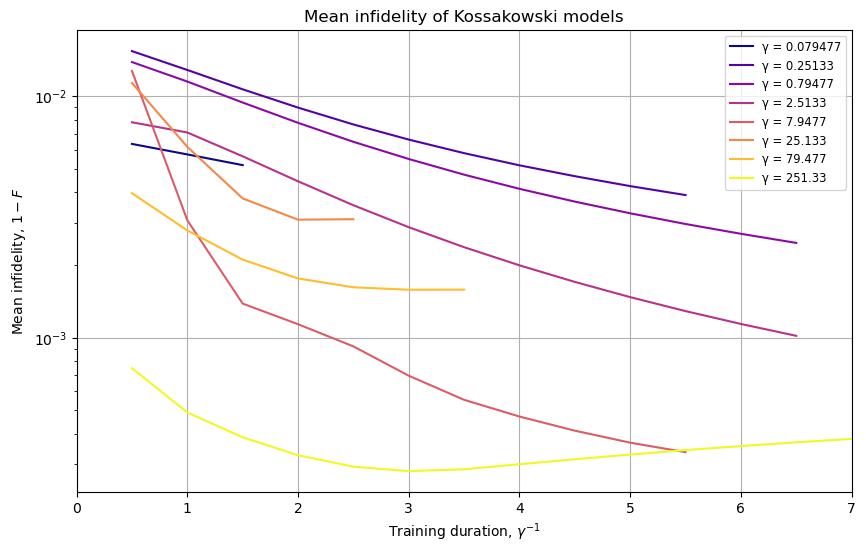

In [55]:
plot_infidelity_stats(fidelity_stats)
